In [1]:
import pandas as pd
import time
import re

#### 데이터 불러오기 (pos 및 특수문자 등 정제된 데이터임. 정제 방법은 깃허브 코드 참고)
#### https://github.com/Ryleyun91/Ryles_Practice/tree/main/DACON
train = pd.read_csv('../DATA/train_data.csv')
test = pd.read_csv('../DATA/test_data.csv')

In [2]:
### 데이터 불러오기 (정제 안 된 것)
train = pd.read_csv("../DATA/open/train.csv")
test = pd.read_csv("../DATA/open/test.csv")

from konlpy.tag import Mecab
mecab = Mecab()

In [3]:
%%time
def pos(x):
    try:
        text = ''
        for word, pos in mecab.pos(str(x)):
            if pos[0] not in ['J','I','E']:
                if type(re.search("\W+|[0-9]", word))!=re.Match: 
                    # and len(word)!=1:
                    text+=" "+word
        return text.strip()
    
    except:
        pass


train["과제명"] = train["과제명"].apply(pos)
train["요약문_연구목표"] = train["요약문_연구목표"].apply(pos)
train["요약문_연구내용"] = train["요약문_연구내용"].apply(pos)
train["요약문_기대효과"] = train["요약문_기대효과"].apply(pos)
train["요약문_한글키워드"] = train["요약문_한글키워드"].apply(pos)

test["과제명"] = test["과제명"].apply(pos)
test["요약문_연구목표"] = test["요약문_연구목표"].apply(pos)
test["요약문_연구내용"] = test["요약문_연구내용"].apply(pos)
test["요약문_기대효과"] = test["요약문_기대효과"].apply(pos)
test["요약문_한글키워드"] = test["요약문_한글키워드"].apply(pos)

CPU times: user 7min, sys: 2.58 s, total: 7min 3s
Wall time: 7min 8s


In [4]:
train_name_key = [str(sent) for sent in train['과제명'] + " " + train['요약문_한글키워드']]
train_goal = [str(sent) for sent in train['요약문_연구목표']]
train_cont = [str(sent) for sent in train['요약문_연구내용']]
train_effect = [str(sent) for sent in train['요약문_기대효과']]
test_name_key = [str(sent) for sent in test['과제명'] + " " + test['요약문_한글키워드']]
test_goal = [str(sent) for sent in test['요약문_연구목표']]
test_cont = [str(sent) for sent in test['요약문_연구내용']]
test_effect = [str(sent) for sent in test['요약문_기대효과']]
train_label = [int(str(answer)) for answer in train['label']]

In [5]:
# EDA
train_name_key_len = [len(str(sent)) for sent in train_name_key]
train_goal_len = [len(str(sent)) for sent in train_goal]
train_cont_len = [len(str(sent)) for sent in train_cont]
train_effect_len = [len(str(sent)) for sent in train_effect]
test_name_key_len = [len(str(sent)) for sent in test_name_key]
test_goal_len = [len(str(sent)) for sent in test_goal]
test_cont_len = [len(str(sent)) for sent in test_cont]
test_effect_len = [len(str(sent)) for sent in test_effect]

(array([2.7730e+03, 1.9785e+04, 1.6780e+04, 3.8300e+03, 3.5000e+02,
        4.6000e+01, 8.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  7. ,  39.3,  71.6, 103.9, 136.2, 168.5, 200.8, 233.1, 265.4,
        297.7, 330. ]),
 <BarContainer object of 10 artists>)

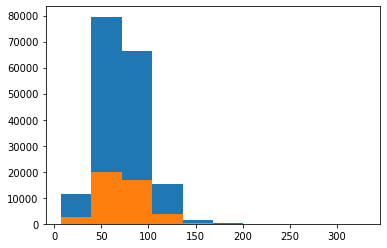

In [6]:
# name_key
import matplotlib.pyplot as plt
plt.hist(train_name_key_len)
plt.hist(test_name_key_len)

## max_len 140정도 주면 커버될 듯

(array([3.2475e+04, 9.0970e+03, 1.5470e+03, 3.1900e+02, 9.6000e+01,
        3.6000e+01, 2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   0.,  373.,  746., 1119., 1492., 1865., 2238., 2611., 2984.,
        3357., 3730.]),
 <BarContainer object of 10 artists>)

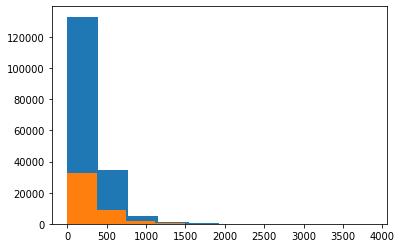

In [7]:
# goal
plt.hist(train_goal_len)
plt.hist(test_goal_len)

## max_len 800정도 주면 커버될 듯

(array([1.4039e+04, 1.4857e+04, 8.2060e+03, 4.2210e+03, 1.6950e+03,
        4.5700e+02, 8.1000e+01, 1.0000e+01, 3.0000e+00, 7.0000e+00]),
 array([   0. ,  354.7,  709.4, 1064.1, 1418.8, 1773.5, 2128.2, 2482.9,
        2837.6, 3192.3, 3547. ]),
 <BarContainer object of 10 artists>)

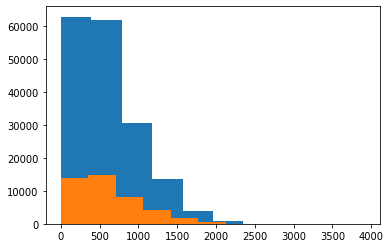

In [8]:
# cont
plt.hist(train_cont_len)
plt.hist(test_cont_len)

## max_len 1500정도 주면 커버될 듯

(array([1.9094e+04, 1.6037e+04, 5.9940e+03, 1.4290e+03, 5.8900e+02,
        2.6500e+02, 8.6000e+01, 6.5000e+01, 1.5000e+01, 2.0000e+00]),
 array([   0.,  264.,  528.,  792., 1056., 1320., 1584., 1848., 2112.,
        2376., 2640.]),
 <BarContainer object of 10 artists>)

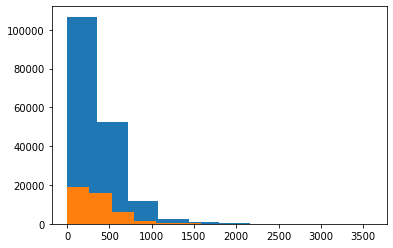

In [9]:
# effect
plt.hist(train_effect_len)
plt.hist(test_effect_len)

## max_len 1000정도 주면 커버될 듯

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Flatten, Dropout
from tensorflow.keras import layers, models
import numpy as np

In [35]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(2021)
np.random.seed(2021)

In [36]:
def CNN(train_data, test_data, maxlen, embedding_dim):
    train_data = np.array(train_data)
    test_data = np.array(test_data)
    tokenizer = Tokenizer(oov_token='<oov>')
    tokenizer.fit_on_texts(train_data)
    word_index = tokenizer.word_index
    train_seq = tokenizer.texts_to_sequences(train_data)
    test_seq = tokenizer.texts_to_sequences(test_data)
    train_pad = pad_sequences(train_seq, maxlen=maxlen, padding='post', truncating='post')
    test_pad = pad_sequences(test_seq, maxlen=maxlen, padding='post', truncating='post')
    
    vocab_size = len(word_index)+1
    dropout = 0.5
    filter_sizes = (2,3,4,5)
    num_filters = 100
    
    # Convolutional block
    input_shape=(maxlen, )
    conv_blocks = []

    model_input = keras.layers.Input(shape=input_shape)

    z = keras.layers.Embedding(vocab_size, embedding_dim, input_length=len(train_data), name="embedding")(model_input)
    z = keras.layers.Dropout(dropout)(z)
    
    for sz in filter_sizes:
        conv = keras.layers.Conv1D(filters=num_filters,
                             kernel_size=sz,
                             padding="Same",
                             activation="relu",
                             strides=1)(z)
        conv = keras.layers.MaxPooling1D(pool_size=2)(conv)
        conv = keras.layers.Flatten()(conv)
        conv_blocks.append(conv)

    z = keras.layers.Concatenate()(conv_blocks)
    z = keras.layers.Dropout(dropout)(z)
    z = keras.layers.Dense(512, activation="relu")(z)
    z = keras.layers.Dropout(dropout)(z)
    z = keras.layers.Dense(256, activation="relu")(z)
    z = keras.layers.Dropout(dropout)(z)
    model_output = keras.layers.Dense(46, activation="softmax")(z)
    model = keras.Model(model_input, model_output)
    print(model.summary())
    model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model, train_pad, test_pad

In [37]:
model, train_pad, test_pad = CNN(train_name_key, test_name_key, 140, 200)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 140, 200)     11319400    input_7[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 140, 200)     0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 140, 100)     40100       dropout_10[0][0]                 
____________________________________________________________________________________________

In [38]:
model.fit(train_pad, np.array(train_label), epochs=13, batch_size=1000, validation_split=0.1, verbose=2)

Epoch 1/13
157/157 - 239s - loss: 1.0063 - accuracy: 0.8116 - val_loss: 0.8619 - val_accuracy: 0.8199
Epoch 2/13
157/157 - 252s - loss: 0.7495 - accuracy: 0.8241 - val_loss: 0.6625 - val_accuracy: 0.8360
Epoch 3/13
157/157 - 250s - loss: 0.6035 - accuracy: 0.8401 - val_loss: 0.5751 - val_accuracy: 0.8528
Epoch 4/13
157/157 - 227s - loss: 0.4890 - accuracy: 0.8609 - val_loss: 0.5058 - val_accuracy: 0.8659
Epoch 5/13
157/157 - 222s - loss: 0.3925 - accuracy: 0.8827 - val_loss: 0.4415 - val_accuracy: 0.8851
Epoch 6/13
157/157 - 219s - loss: 0.3260 - accuracy: 0.9023 - val_loss: 0.4281 - val_accuracy: 0.8919
Epoch 7/13
157/157 - 218s - loss: 0.2784 - accuracy: 0.9156 - val_loss: 0.4267 - val_accuracy: 0.8962
Epoch 8/13
157/157 - 218s - loss: 0.2400 - accuracy: 0.9274 - val_loss: 0.4320 - val_accuracy: 0.9057
Epoch 9/13
157/157 - 221s - loss: 0.2126 - accuracy: 0.9354 - val_loss: 0.4392 - val_accuracy: 0.9082
Epoch 10/13
157/157 - 228s - loss: 0.1901 - accuracy: 0.9429 - val_loss: 0.4551 - 

In [39]:
answer = model.predict(test_pad)

In [40]:
# 모델 예측
import tensorflow as tf
pred = tf.argmax(answer, axis=1)

In [43]:
import numpy as np
np.sum(pred !=0)

8212

In [44]:
sample_submission=pd.read_csv('../DATA/open/sample_submission.csv')
sample_submission['label']=pred
sample_submission.to_csv('../DATA/Result/CNN_filter.csv', index=False)